In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

#from imutils import paths
from pathlib import Path
import os, sys
import time
import copy

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

from lucent.modelzoo.util import get_model_layers

# Local modules
from cub_tools.train import train_model
from cub_tools.visualize import imshow, visualize_model
from cub_tools.utils import unpickle, save_pickle
from cub_tools.transforms import makeDefaultTransforms
from cub_tools.data import ImageFolderWithPaths
from cub_tools.layer_feature_maps import extract_feature_maps

# Activation vectors and spatial activations

![CNN Layers](../docs/CNN_layers.png)

In this notebook, we are going to take a single image and investigate the features that lead to the prediction of the class. We will attempt to visualise what types of features the network activates on given the input image. For this process we need:

1. Select an image for input from the input dataset, and select a layer to visualise.

2. Extract the activations for the given layer, yielding a 3D volume of neurons (nx,ny,n_channels).

3. Select a neuron (x,y) and then get the neurons that are most activated in that vector.

4. Maximally activate these neurons using the input image, and combine the activations together to produce a spatial activation.

5. Activations can be maximised for all spatial activations to yield an activation map across the whole image.

In [2]:
# Script runtime options
root_dir = '..'
model = 'resnext101_32x8d'
data_root_dir = os.path.join(root_dir, 'data')
model_root_dir = os.path.join(root_dir, 'models')
stages = ['test']


# Paths setup
data_dir = os.path.join(data_root_dir,'images')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_history = os.path.join(output_dir,'model_history.pkl')
model_file = os.path.join(output_dir, 'caltech_birds_{}_full.pth'.format(model))

In [3]:
# Get data transforms
data_transforms = makeDefaultTransforms(img_crop_size=224, img_resize=256)

In [4]:
# Setup data loaders with augmentation transforms
image_datasets = {x: ImageFolderWithPaths(os.path.join(data_dir, x), data_transforms[x])
                  for x in stages}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in stages}
dataset_sizes = {x: len(image_datasets[x]) for x in stages}
class_names = image_datasets[stages[0]].classes

In [5]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


In [6]:
# Load the best model from file
model_ = torch.load(model_file)

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by acc

In [7]:
get_model_layers(model_)

['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer1_0',
 'layer1_0_conv1',
 'layer1_0_bn1',
 'layer1_0_conv2',
 'layer1_0_bn2',
 'layer1_0_conv3',
 'layer1_0_bn3',
 'layer1_0_relu',
 'layer1_0_downsample',
 'layer1_0_downsample_0',
 'layer1_0_downsample_1',
 'layer1_1',
 'layer1_1_conv1',
 'layer1_1_bn1',
 'layer1_1_conv2',
 'layer1_1_bn2',
 'layer1_1_conv3',
 'layer1_1_bn3',
 'layer1_1_relu',
 'layer1_2',
 'layer1_2_conv1',
 'layer1_2_bn1',
 'layer1_2_conv2',
 'layer1_2_bn2',
 'layer1_2_conv3',
 'layer1_2_bn3',
 'layer1_2_relu',
 'layer2',
 'layer2_0',
 'layer2_0_conv1',
 'layer2_0_bn1',
 'layer2_0_conv2',
 'layer2_0_bn2',
 'layer2_0_conv3',
 'layer2_0_bn3',
 'layer2_0_relu',
 'layer2_0_downsample',
 'layer2_0_downsample_0',
 'layer2_0_downsample_1',
 'layer2_1',
 'layer2_1_conv1',
 'layer2_1_bn1',
 'layer2_1_conv2',
 'layer2_1_bn2',
 'layer2_1_conv3',
 'layer2_1_bn3',
 'layer2_1_relu',
 'layer2_2',
 'layer2_2_conv1',
 'layer2_2_bn1',
 'layer2_2_conv2',
 'layer2_2_bn2',
 'layer

This function appends a hook to the forward calculation, as the image is filtered through the network and causes activations of the neurons contained within in each layer. The function appends the output of the layer the hook is attached to, to the global variable list specificed outside the function. The hook can be appended to multiple layers, where each layer output is appended to the list sequentially.

The list order is as follows:

    |--image 1 layer 1--|
    |--image 1 layer 2--|
    |--image 1 layer N--|
    |--image M layer N--|

The total length of the list will be number layers with the hook added times the number of images passed through the network.

In [8]:
fc_feature_extractions= []
def hook(module, input, output):
    fc_feature_extractions.append(output)

In [9]:
def sort_layer_feature_maps(unsorted_feat_maps, num_images):
    
    num_layers = np.int(len(unsorted_feat_maps)/num_images)
    sorted_feature_maps = {}
    for i_layer in np.arange(0,num_layers,1):
        sorted_feature_maps[i_layer] = []
    
    i=0
    for i_image in np.arange(0,num_images,1):
        for i_layer in np.arange(0,num_layers,1):
            sorted_feature_maps[i_layer].append(unsorted_feat_maps[i])
            i += 1
            
    return sorted_feature_maps

def layer_feature_maps_extraction(layer_ref, model, dataloader, device, batch_limit):
    
    layer_feature_extraction= []
    def hook(module, input, output):
        layer_feature_extraction.append(output)
    
    # Register the hook for the given layer
    layer_ref.register_forward_hook(hook)
    
    layer_feature_extractions_dict = extract_feature_maps(model=model_, 
                                                          dataloader=dataloaders['test'], 
                                                          fc_feature_extractions=layer_feature_extractions, 
                                                          device=device,
                                                          batch_limit=batch_limit)
    
    return layer_feature_extractions_dict

In [10]:
model_.layer1.register_forward_hook(hook)
model_.layer2.register_forward_hook(hook)
model_.layer3.register_forward_hook(hook)
model_.layer4.register_forward_hook(hook)
model_.avgpool.register_forward_hook(hook)

feature_extractions_dict = extract_feature_maps(model=model_, 
                                                dataloader=dataloaders['test'], 
                                                fc_feature_extractions=fc_feature_extractions, 
                                                device=device,
                                                batch_limit=100)

sorted_feature_maps = sort_layer_feature_maps(feature_extractions_dict['feature extractions'], 100)

Commencing predictions and feature extraction minibatch..0..25..50..75..100....exiting at specified batch limit (100)


ResNeXt structure

In this diagram, layer 1 refers to Conv 2, layer 2 to Conv 3, layer 3 to Conv 4 and layer 4 to Conv 5.

![Image](https://pytorch.org/assets/images/resnext.png)

![Image](https://miro.medium.com/max/1286/1*mdiQTfovOXKnqzfj727b9Q.png)

ResNeXt output structure:

    Layer 1 has 256 channels and an output of size 56 x 56.
    
    Layer 2 has 512 channels and an output of size 28 x 28.
    
    Layer 3 has 1024 channels and an output of size 14 x 14.
    
    Layer 4 has 2048 channels and an output of size 7 x 7.
    
    Final layer is Average Pooling layer with 2048 channels with single neuron.

In [12]:
layerNames = ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Final Ave Pool']
for i_layer in np.arange(0,5,1):
    print('{} : {} : {}'.format(i_layer, sorted_feature_maps[i_layer][0].shape, layerNames[i_layer]))

0 : (1, 256, 56, 56) : Layer 1
1 : (1, 512, 28, 28) : Layer 2
2 : (1, 1024, 14, 14) : Layer 3
3 : (1, 2048, 7, 7) : Layer 4
4 : (1, 2048, 1, 1) : Final Ave Pool


In [13]:
def plot_layer_channel_feature_maps(layer_feature_maps, n_act_cols=24, plot_vert_scale_factor=2, image_truth='', image_pred='', layer_name=''):
    
    layer_shape = layer_feature_maps.squeeze().shape
    n_act_rows =np.int(np.ceil(layer_shape[0]/n_act_cols))
    act_max = layer_feature_maps.squeeze().max()

    plt.figure(figsize=(35,plot_vert_scale_factor*n_act_rows))
    plt.suptitle('Image Truth: {}, Image Pred: {}, Layer Name: {}'.format(image_truth,image_pred,layer_name))
    for i_channel in np.arange(0,layer_shape[0],1):
        plt.subplot(n_act_rows,n_act_cols,i_channel+1)
        plt.imshow(layer_feature_maps.squeeze()[i_channel,:,:]/act_max)
        plt.title('Channel:: {}'.format(i_channel))
        #plt.xticks([])
        #plt.yticks([])

plt.show()

IndexError: too many indices for array

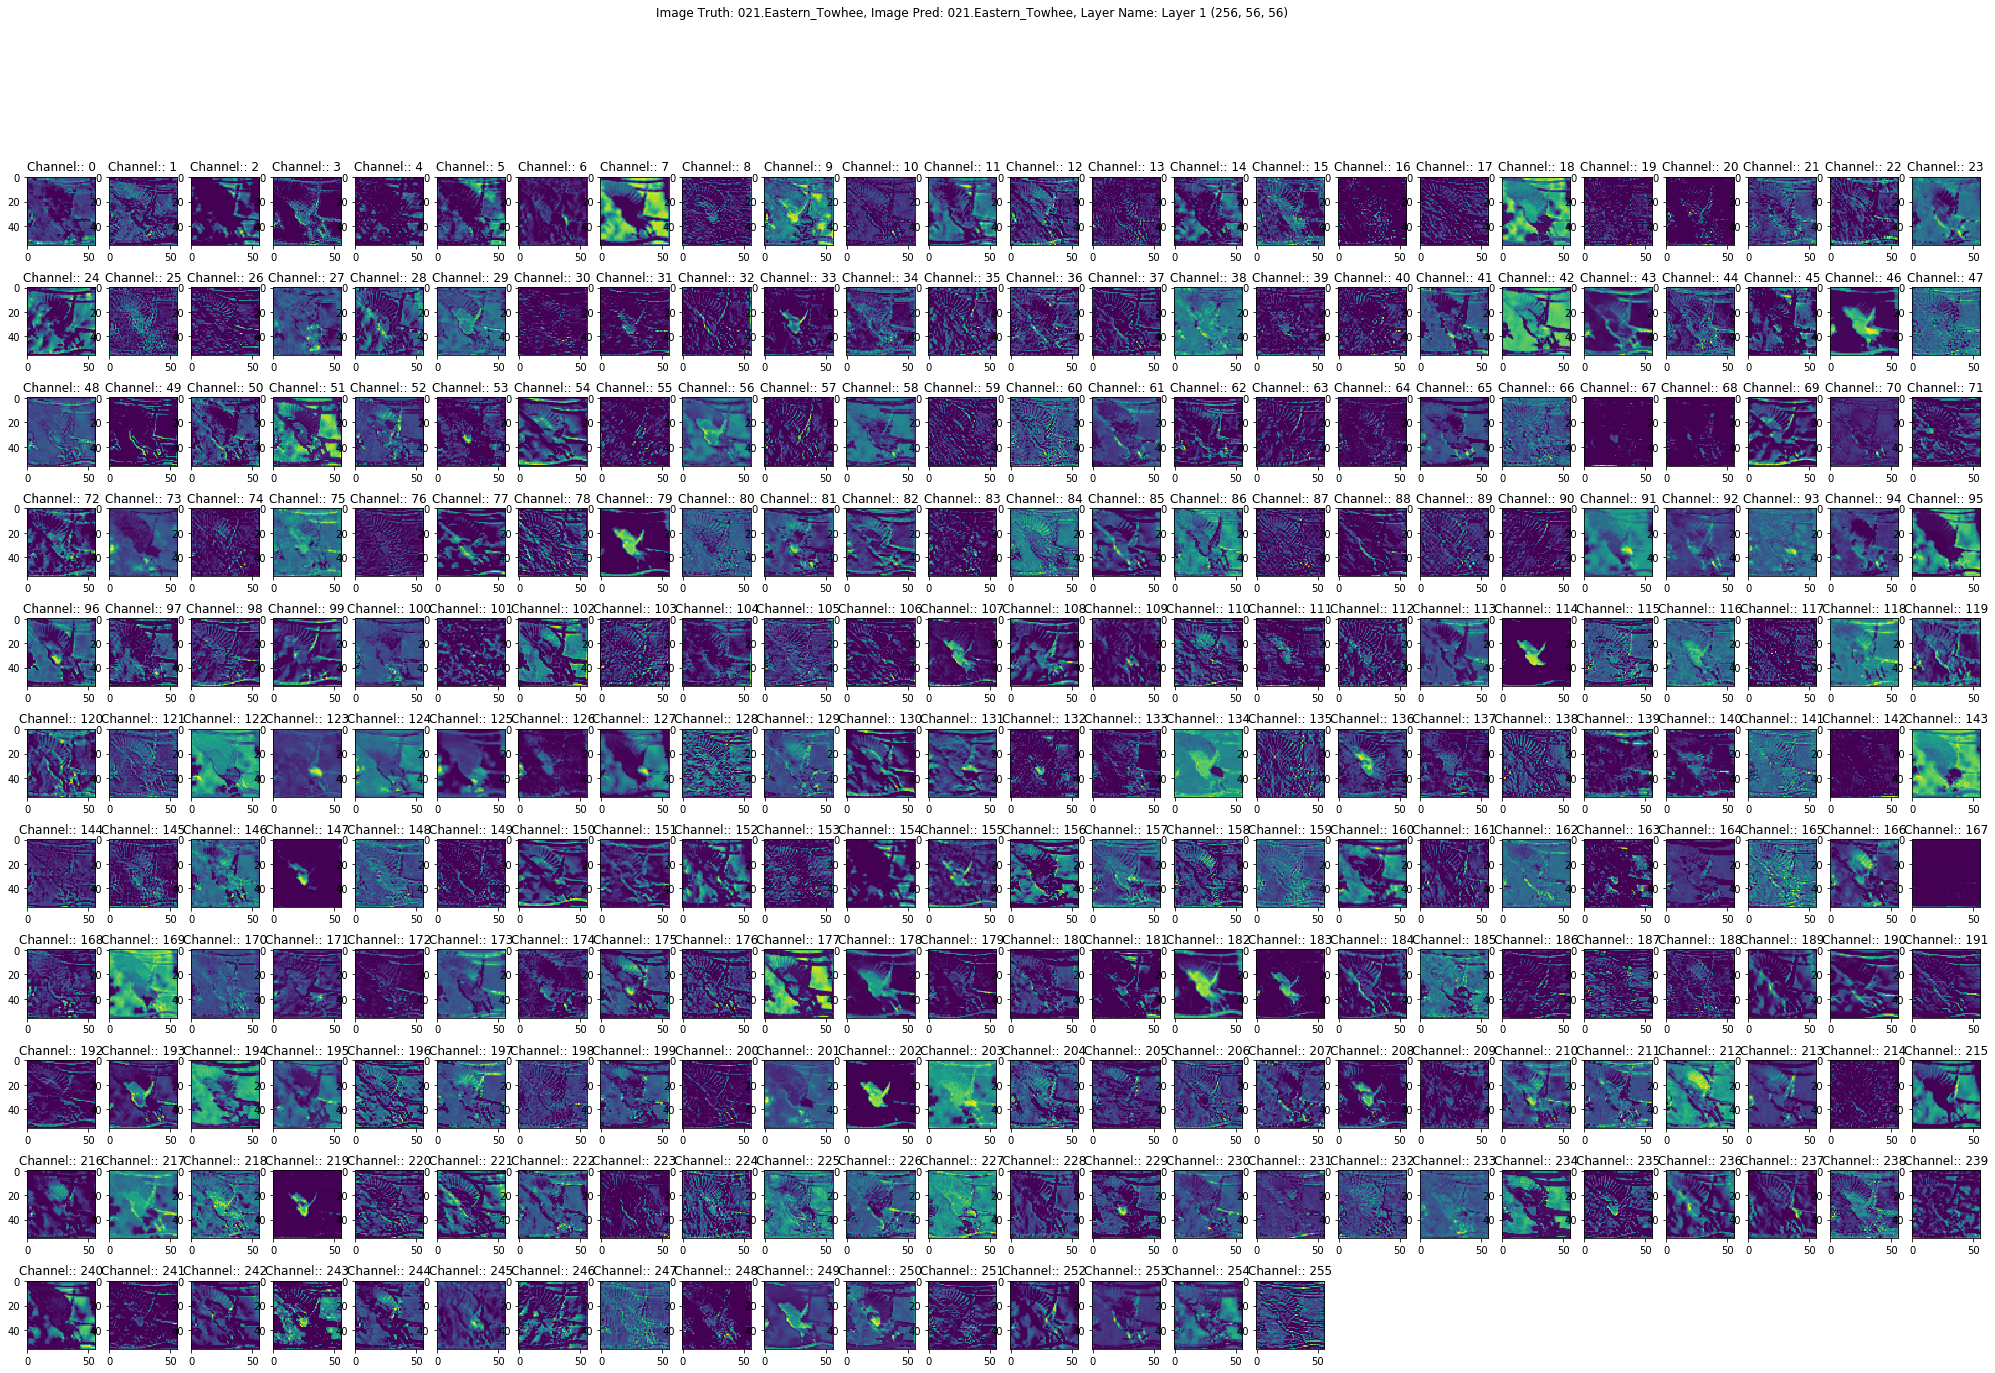

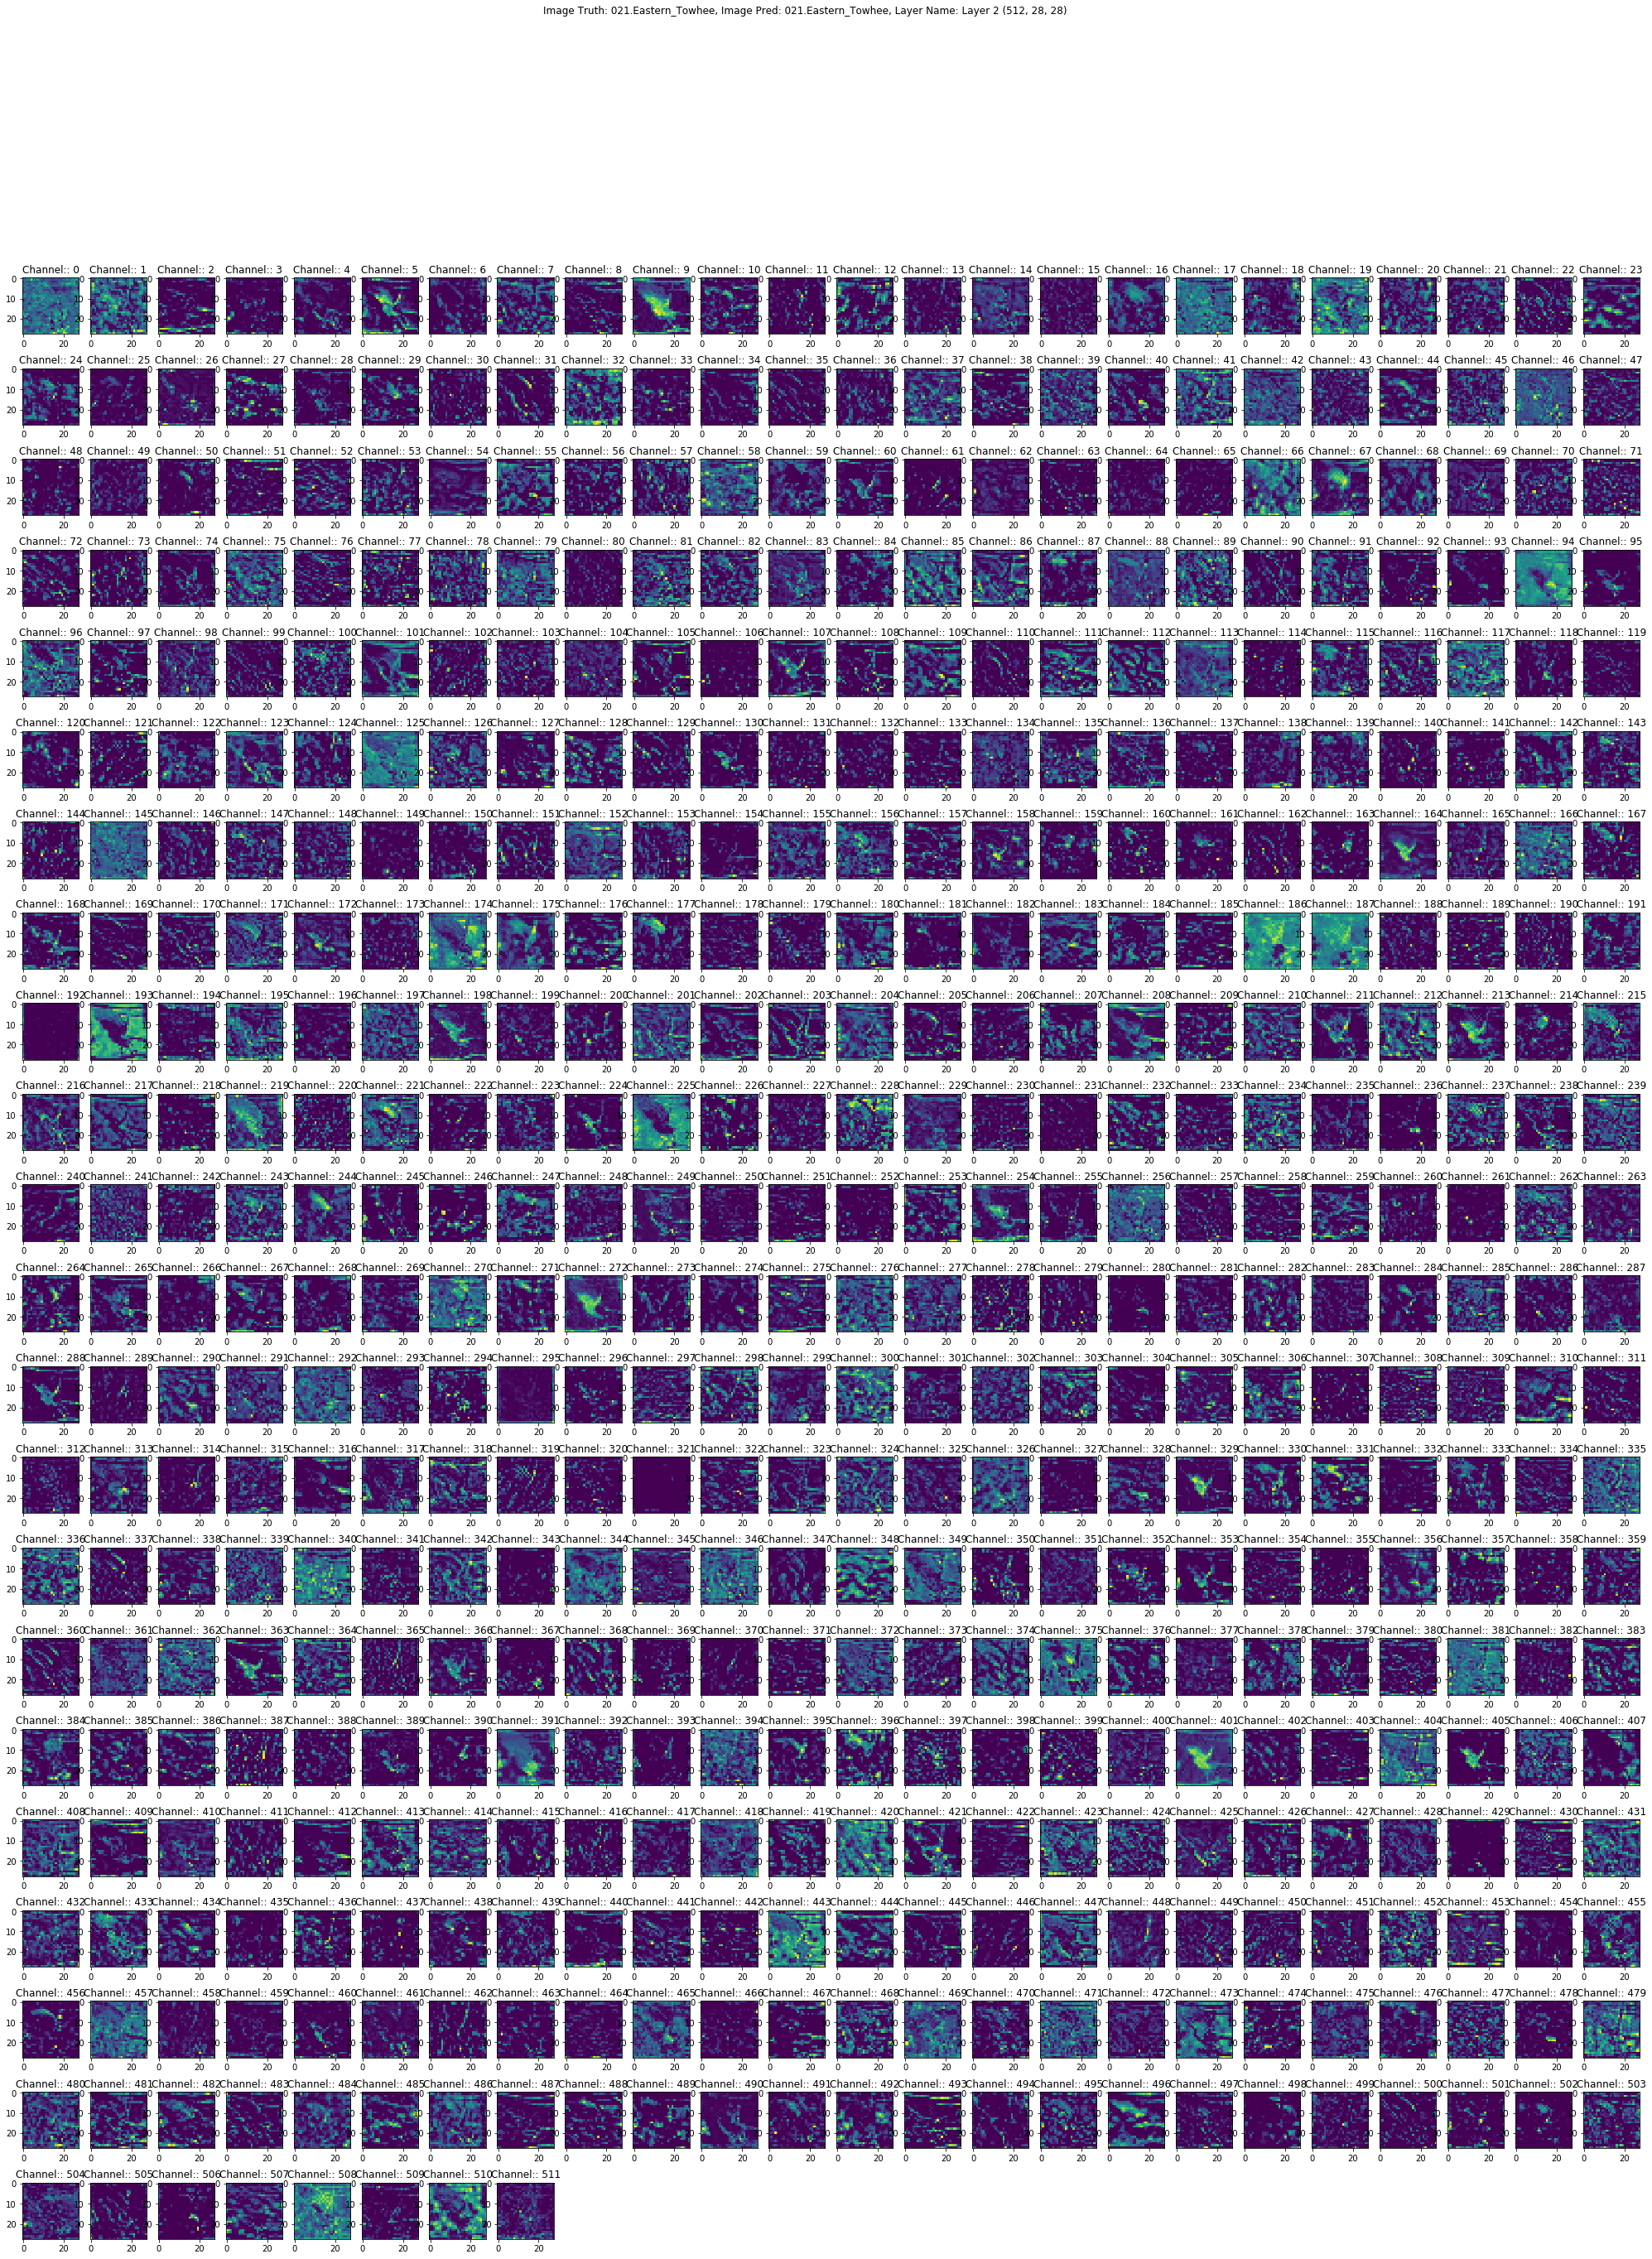

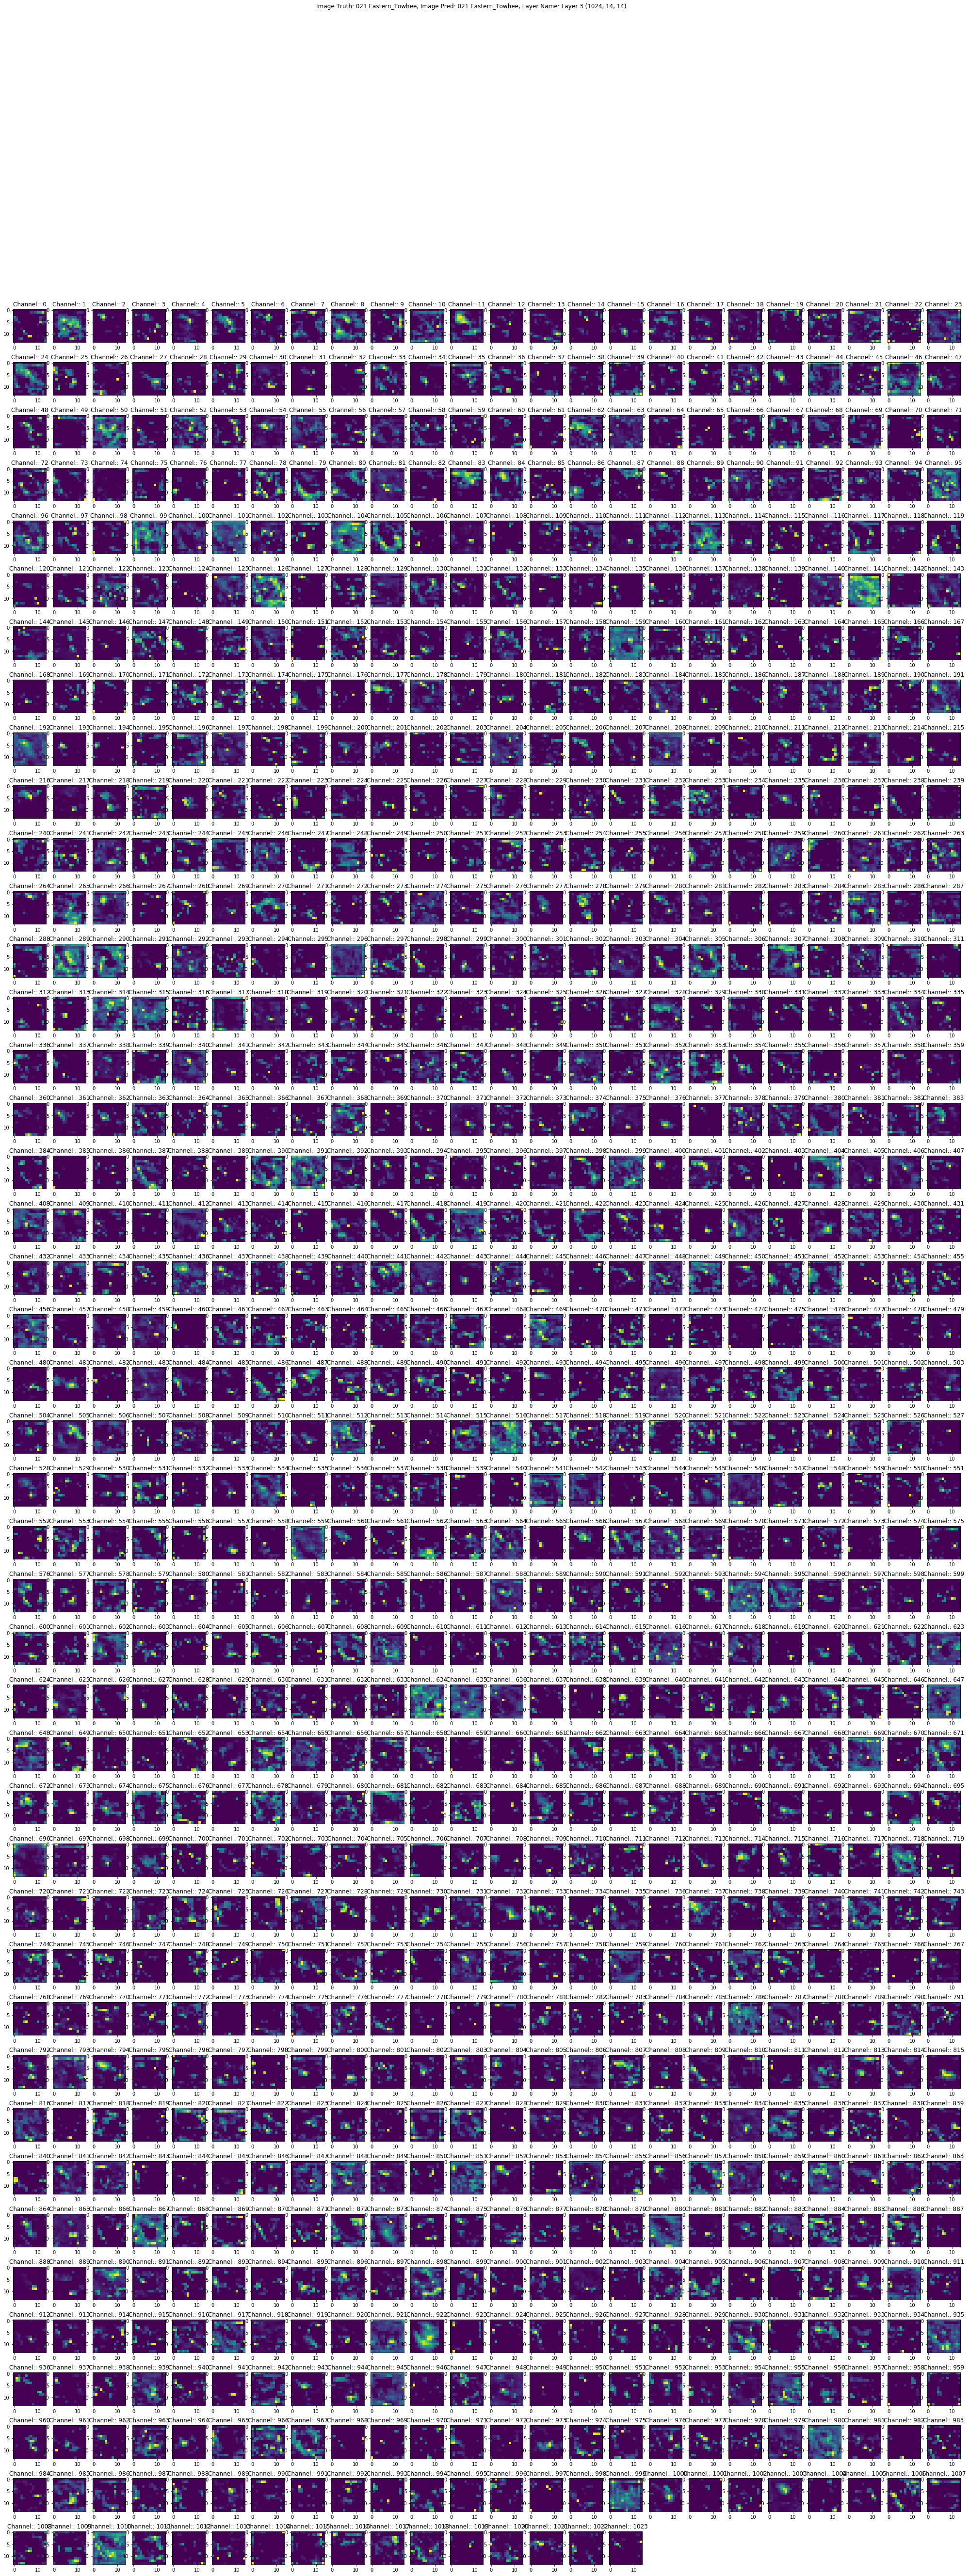

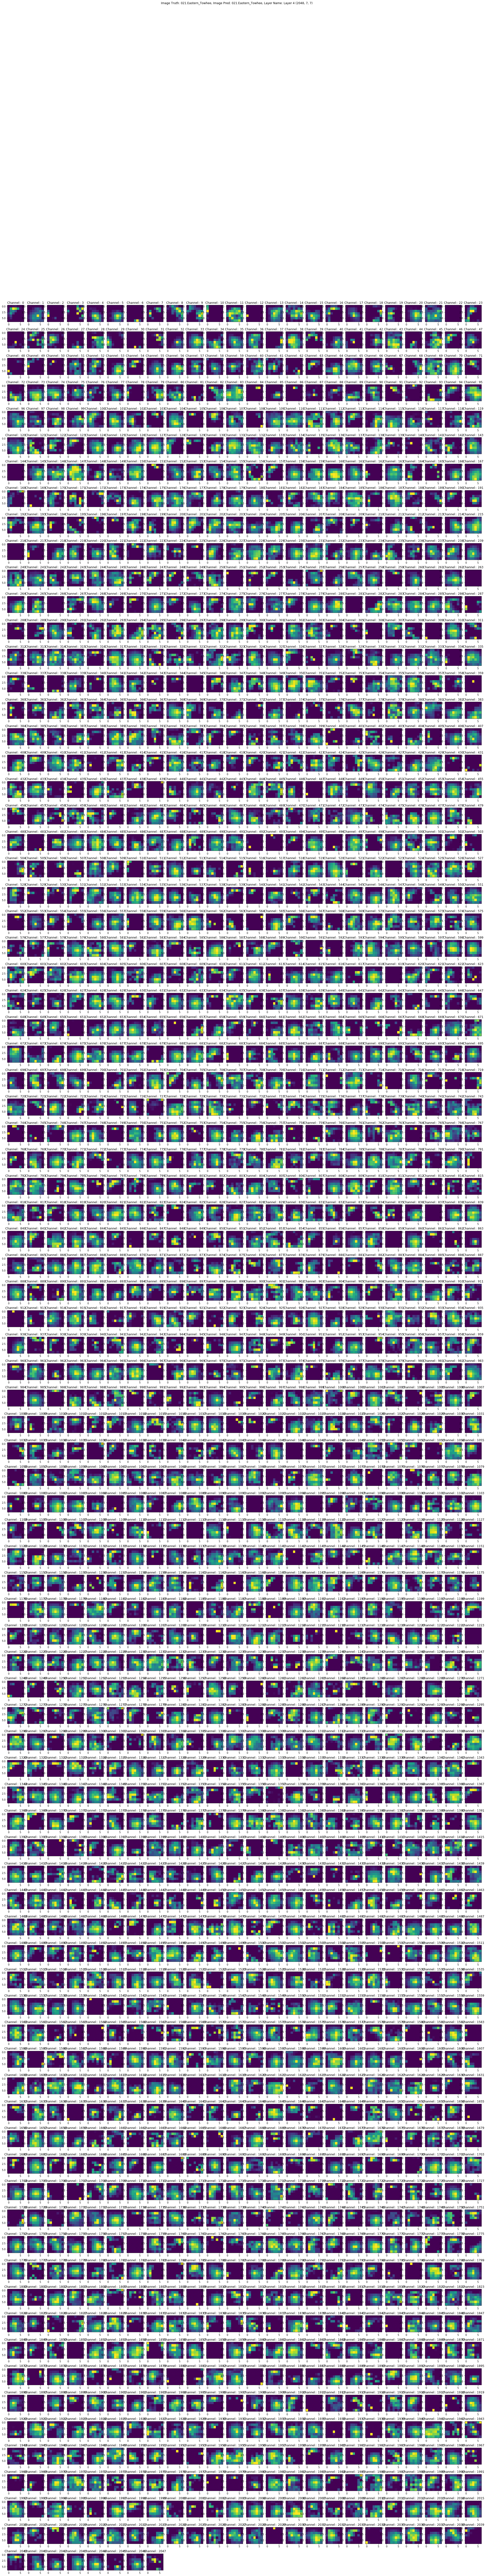

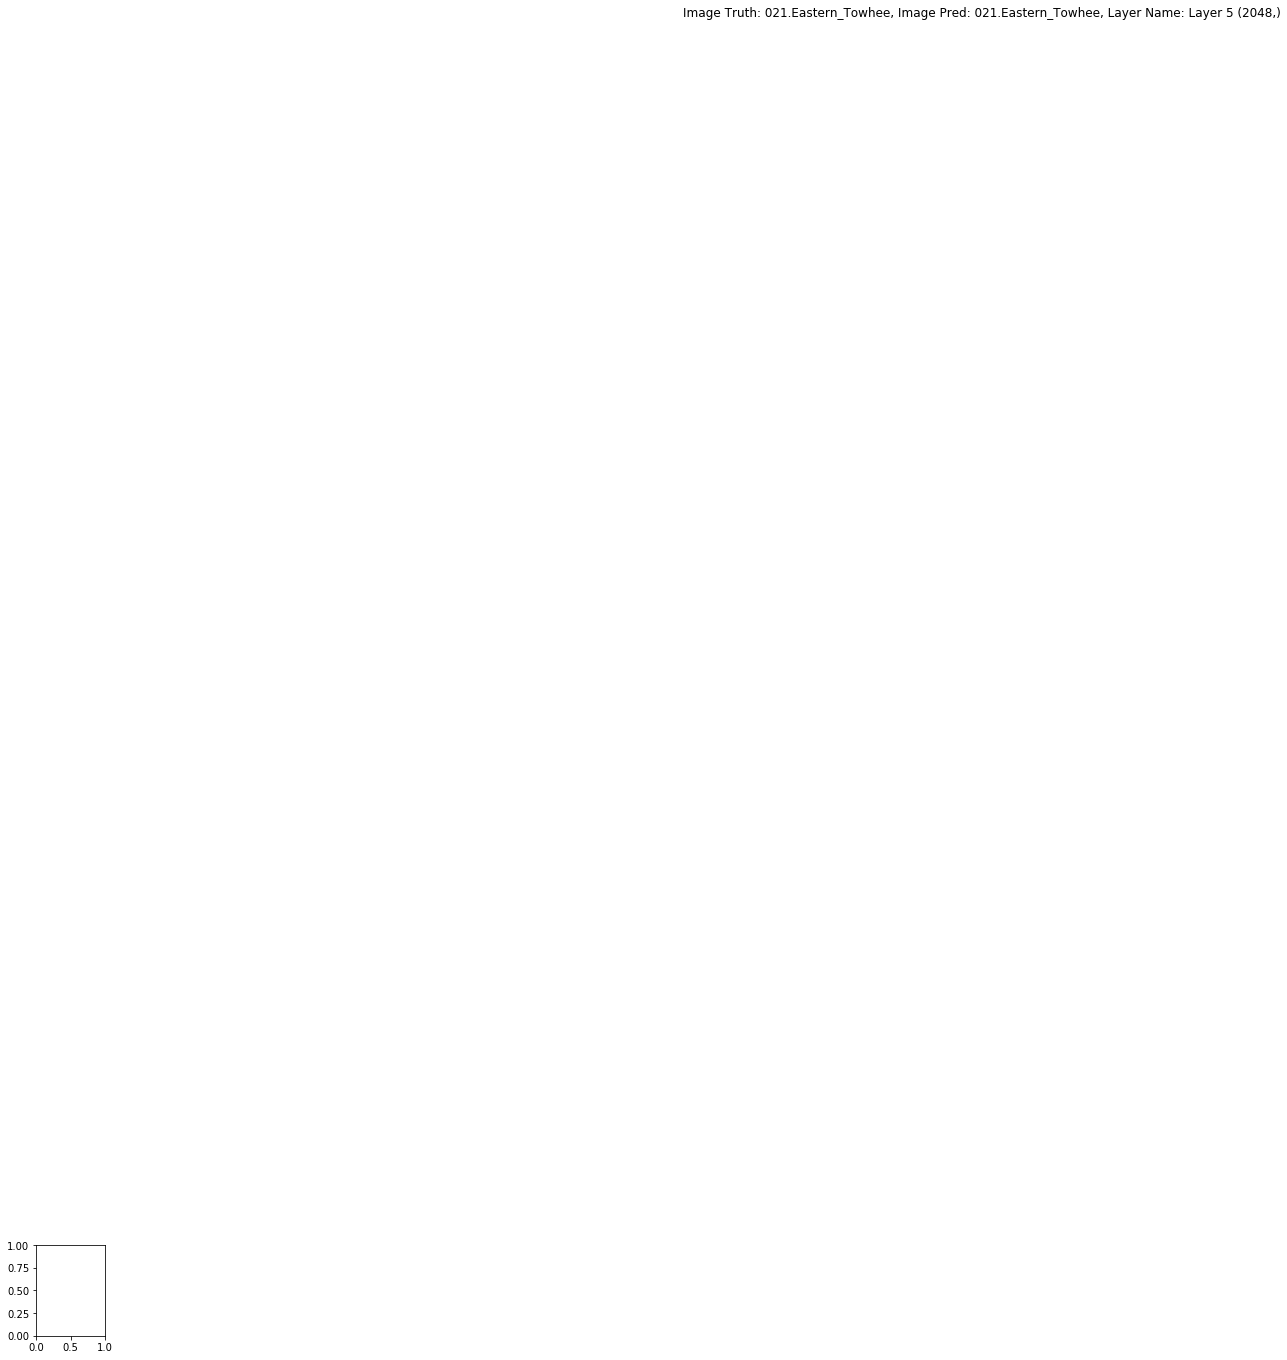

In [16]:
layer_id = 0
image_id = 0

for layer_id in np.arange(0,5,1):
    plot_layer_channel_feature_maps(sorted_feature_maps[layer_id][image_id], n_act_cols=24, 
                                    image_truth=class_names[feature_extractions_dict['labels truth'][image_id]], 
                                    image_pred=class_names[feature_extractions_dict['labels pred'][image_id]], 
                                    layer_name='Layer {} {}'.format(layer_id+1, sorted_feature_maps[layer_id][image_id].squeeze().shape))

In [ ]:
layer_id=5
img_id=int(layer_id/5)

layerShape = feature_extractions_dict['feature extractions'][layer_id].shape
plt.figure(figsize=(35,15))
plt.imshow(feature_extractions_dict['feature extractions'][layer_id].squeeze().reshape(layerShape[1],layerShape[2]*layerShape[3]))
plt.title('True Label:: {}, Predicted Label:: {}'.format(class_names[feature_extractions_dict['labels truth'][img_id]],class_names[feature_extractions_dict['labels pred'][img_id]]))

layer_id += 1
layerShape = feature_extractions_dict['feature extractions'][layer_id].shape
plt.figure(figsize=(35,15))
plt.imshow(feature_extractions_dict['feature extractions'][layer_id].squeeze().reshape(layerShape[1],layerShape[2]*layerShape[3]))
plt.title('True Label:: {}, Predicted Label:: {}'.format(class_names[feature_extractions_dict['labels truth'][img_id]],class_names[feature_extractions_dict['labels pred'][img_id]]))

layer_id += 1
layerShape = feature_extractions_dict['feature extractions'][layer_id].shape
plt.figure(figsize=(35,15))
plt.imshow(feature_extractions_dict['feature extractions'][layer_id].squeeze().reshape(layerShape[1],layerShape[2]*layerShape[3]))
plt.title('True Label:: {}, Predicted Label:: {}'.format(class_names[feature_extractions_dict['labels truth'][img_id]],class_names[feature_extractions_dict['labels pred'][img_id]]))

plt.show()



In [ ]:
save_pickle(feature_extractions_dict, '../models/classification/{}/{}_feature_extractions.pkl'.format(model,model))

In [ ]:
feature_extractions_dict['feature extractions'][0].shape

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(np.arange(0,feature_extractions_dict['feature extractions'][0].shape[1],1),
         feature_extractions_dict['feature extractions'][0].ravel())
plt.grid(True)
plt.show()